run: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.04it/s]


run: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.03it/s]


run: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.03it/s]


run: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.99it/s]


run: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.99it/s]


run: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.03it/s]


run: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]


run: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.99it/s]


run: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.98it/s]


run: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.98it/s]


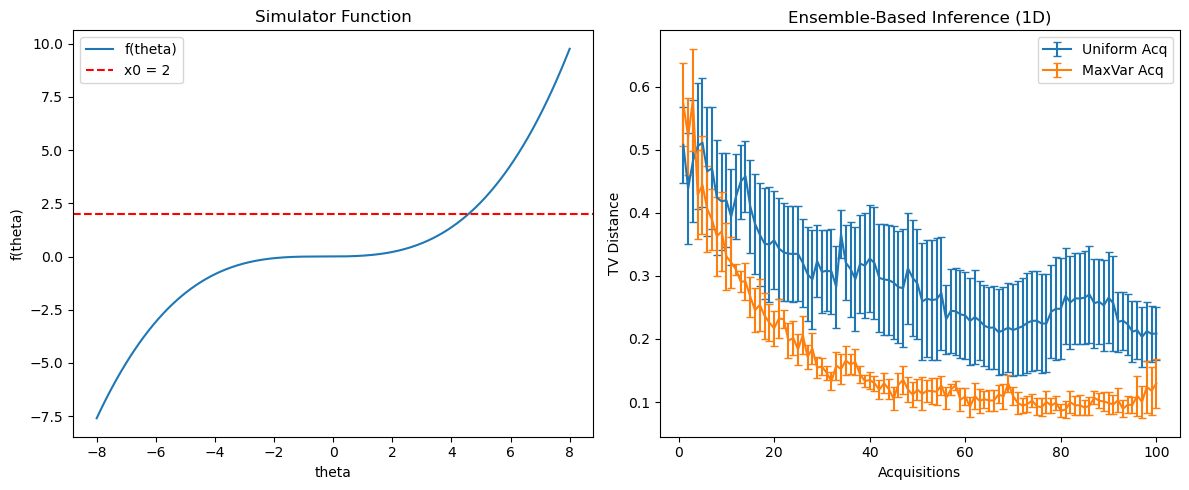

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# --- Simulator and True Likelihood Definitions ------------------------------

def f_1d(theta):
    """
    Cubic nonlinearity, f(theta) = ((1.5*theta + 0.5)**3) / 200.
    theta can be a numpy array.
    """
    return ((1.5 * theta + 0.5) ** 3) / 200

def simulator_1d(theta, sigma=0.31622777):
    """Generate a simulated observation x ~ N(f(theta), sigma^2)."""
    mean = f_1d(theta)
    return np.random.normal(mean, sigma)

def true_log_likelihood_1d(theta, x0=2, sigma=0.31622777):
    """
    Compute the true log-likelihood: log p(x0|theta) = log N(x0; f(theta), sigma^2)
    """
    mean = f_1d(theta)
    return -0.5*np.log(2*np.pi*sigma**2) - 0.5*((x0 - mean)**2)/(sigma**2)

def true_posterior_1d(theta_grid, x0=2, sigma=0.31622777):
    """Compute the (normalized) true posterior on a grid (prior is uniform)."""
    ll = np.exp(true_log_likelihood_1d(theta_grid, x0, sigma))
    post = ll  # uniform prior constant => p(theta|x0) ∝ likelihood
    norm = np.trapz(post, theta_grid) + 1e-10
    return post / norm

# --- Neural Network Ensemble Definition ---------------------------------------

class EmulatorNet(nn.Module):
    """
    A simple feedforward network that predicts the parameters of a Gaussian distribution.
    Input: theta (1D)
    Output: [mu, log_sigma] where sigma = exp(log_sigma)
    Architecture: one hidden layer with 10 tanh units.
    """
    def __init__(self):
        super(EmulatorNet, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(10, 2)  # outputs: mu and log_sigma
    
    def forward(self, x):
        # x is expected to be of shape (batch, 1)
        h = self.act(self.fc1(x))
        out = self.fc2(h)
        return out  # shape: (batch, 2)

def nll_loss(output, target):
    """
    Negative log likelihood loss for a Gaussian likelihood.
    output: tensor of shape (batch, 2) -> [mu, log_sigma]
    target: tensor of shape (batch, 1)
    """
    mu = output[:, 0].unsqueeze(1)
    log_sigma = output[:, 1].unsqueeze(1)
    sigma = torch.exp(log_sigma) + 1e-6  # ensure positivity
    # Using the closed-form Gaussian NLL loss:
    loss = 0.5 * torch.log(2*np.pi*sigma**2) + 0.5 * ((target - mu)**2)/(sigma**2)
    return torch.mean(loss)

# --- Training Functions for the Ensemble ------------------------------------

def train_ensemble(models, optimizers, theta_tensor, x_tensor, epochs=200):
    """
    Train each ensemble member on the current dataset.
    models: list of EmulatorNet instances.
    optimizers: list of optimizers (one per model).
    theta_tensor: tensor of shape (N, 1)
    x_tensor: tensor of shape (N, 1)
    """
    for epoch in range(epochs):
        for model, optimizer in zip(models, optimizers):
            model.train()
            optimizer.zero_grad()
            outputs = model(theta_tensor)
            loss = nll_loss(outputs, x_tensor)
            loss.backward()
            optimizer.step()

def ensemble_predict(models, theta_candidates, x0=2, sigma_min=1e-6):
    """
    For a set of candidate theta values, compute the synthetic likelihood q(x0|theta)
    for each ensemble member and return an array of shape (n_candidates, n_models).
    The likelihood for a given network is computed as:
        L = N(x0; mu(theta), sigma(theta)^2)
    """
    models_eval = [model.eval() for model in models]
    theta_tensor = torch.tensor(theta_candidates.reshape(-1, 1), dtype=torch.float32)
    with torch.no_grad():
        all_preds = []
        for model in models:
            outputs = model(theta_tensor)  # (n_candidates, 2)
            mu = outputs[:, 0].numpy()
            log_sigma = outputs[:, 1].numpy()
            sigma = np.exp(log_sigma) + sigma_min
            # Compute the likelihood density using the Gaussian PDF
            L = (1.0/np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5*((x0 - mu)**2)/(sigma**2))
            all_preds.append(L)
        # Shape: (n_models, n_candidates) --> transpose to (n_candidates, n_models)
        all_preds = np.array(all_preds).T
    return all_preds

# --- Acquisition Rule (MaxVar) -----------------------------------------------
def acquisition_maxvar_ensemble(models, grid, x0=2):
    """
    Evaluate the ensemble synthetic likelihood on a grid of theta values,
    and return the theta corresponding to the maximum sample variance across ensemble predictions.
    """
    preds = ensemble_predict(models, grid, x0)
    # For each candidate theta, compute the sample variance across ensemble members
    var_preds = np.var(preds, axis=1)
    idx = np.argmax(var_preds)
    return grid[idx]

def acquisition_uniform_ensemble():
    """Uniform acquisition: return a random theta from the prior."""
    return np.random.uniform(-8, 8)

# --- Main Simulation Loop using the Neural Network Ensemble -----------------
def run_simulation_ensemble(acquisition_rule='maxvar', N_initial=10, N_acq=100, x0=2, sigma=0.31622777,
                            ensemble_size=10, epochs_per_round=200):
    """
    Run one simulation run using a neural network ensemble.
      - acquisition_rule: either 'uniform' or 'maxvar'
      - N_initial: initial sample count
      - N_acq: number of acquisition rounds
      - ensemble_size: number of ensemble members
      - epochs_per_round: training epochs for each acquisition round
    Returns:
      tv_errors: list of total variation distances (one per acquisition round)
      data: (theta, x) arrays for inspection if needed.
    """
    # --- Initialize the training data -------------------------------
    thetas = np.random.uniform(-8, 8, size=N_initial)
    x_samples = np.array([simulator_1d(t, sigma) for t in thetas])
    # Convert to torch tensors (shape: (N, 1))
    theta_tensor = torch.tensor(thetas.reshape(-1, 1), dtype=torch.float32)
    x_tensor = torch.tensor(x_samples.reshape(-1, 1), dtype=torch.float32)
    
    # Initialize ensemble
    models = [EmulatorNet() for _ in range(ensemble_size)]
    optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]
    
    # Set up evaluation grid over theta for posterior reconstruction
    grid = np.linspace(-8, 8, 400)
    true_post = true_posterior_1d(grid, x0, sigma)
    
    tv_errors = []
    
    for acq in trange(N_acq):
        # Train the ensemble on the current dataset
        train_ensemble(models, optimizers, theta_tensor, x_tensor, epochs=epochs_per_round)
        
        # Predict synthetic likelihood on the grid
        preds = ensemble_predict(models, grid, x0)  # shape (len(grid), ensemble_size)
        # Average across the ensemble to get synthetic likelihood estimate
        L_est = np.mean(preds, axis=1)
        # Obtain synthetic posterior (proportional to L_est, uniform prior)
        post_est = L_est / (np.trapz(L_est, grid) + 1e-10)
        # Compute TV distance between synthetic posterior and true posterior
        dtheta = grid[1] - grid[0]
        tv = 0.5 * np.sum(np.abs(post_est - true_post)) * dtheta
        tv_errors.append(tv)
        
        # Acquisition: choose new theta according to rule
        if acquisition_rule == 'uniform':
            new_theta = acquisition_uniform_ensemble()
        elif acquisition_rule == 'maxvar':
            new_theta = acquisition_maxvar_ensemble(models, grid, x0)
        else:
            raise ValueError("Unknown acquisition rule: choose 'uniform' or 'maxvar'")
        
        # Simulate a new observation at the new theta
        new_x = simulator_1d(new_theta, sigma)
        # Append new data to the training set
        thetas = np.append(thetas, new_theta)
        x_samples = np.append(x_samples, new_x)
        theta_tensor = torch.tensor(thetas.reshape(-1, 1), dtype=torch.float32)
        x_tensor = torch.tensor(x_samples.reshape(-1, 1), dtype=torch.float32)
        
    return tv_errors, (thetas, x_samples)

# --- Evaluate Ensemble Inference over Multiple Runs --------------------------
def evaluate_ensemble(N_runs=5, N_initial=10, N_acq=100, rule='maxvar', ensemble_size=10, epochs_per_round=200):
    all_tv = []
    for run in range(N_runs):
        print(f'run: {run}')
        tv, _ = run_simulation_ensemble(acquisition_rule=rule, N_initial=N_initial, N_acq=N_acq,
                                        ensemble_size=ensemble_size, epochs_per_round=epochs_per_round)
        all_tv.append(tv)
    return np.array(all_tv)

# Run ensemble simulations with maxvar and uniform acquisitions
print('---- max var ----')
tv_maxvar_ensemble = evaluate_ensemble(rule='maxvar')
print('---- uniform ----')
tv_uniform_ensemble = evaluate_ensemble(rule='uniform')

acq_steps = np.arange(1, 101)
mean_maxvar = tv_maxvar_ensemble.mean(axis=0)
mean_uniform = tv_uniform_ensemble.mean(axis=0)
sem_maxvar = tv_maxvar_ensemble.std(axis=0) / np.sqrt(tv_maxvar_ensemble.shape[0])
sem_uniform = tv_uniform_ensemble.std(axis=0) / np.sqrt(tv_uniform_ensemble.shape[0])

# --- Plotting the Results -----------------------------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# (a) Plot the simulator function f(theta) and the observed x0
theta_grid = np.linspace(-8, 8, 400)
plt.plot(theta_grid, f_1d(theta_grid), label='f(theta)')
plt.axhline(2, color='r', linestyle='--', label='x0 = 2')
plt.xlabel('theta')
plt.ylabel('f(theta)')
plt.title('Simulator Function')
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(acq_steps, mean_uniform, yerr=sem_uniform, label='Uniform Acq', capsize=3)
plt.errorbar(acq_steps, mean_maxvar, yerr=sem_maxvar, label='MaxVar Acq', capsize=3)
plt.xlabel('Acquisitions')
plt.ylabel('TV Distance')
plt.title('Ensemble-Based Inference (1D)')
plt.legend()
plt.tight_layout()
plt.show()


  0%|                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s]

Run 1/5 for maxmi acquisition...


 20%|███████████████████████████████████▊                                                                                                                                               | 1/5 [00:47<03:10, 47.72s/it]

Run 2/5 for maxmi acquisition...


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 2/5 [01:36<02:25, 48.35s/it]

Run 3/5 for maxmi acquisition...


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 3/5 [02:25<01:36, 48.48s/it]

Run 4/5 for maxmi acquisition...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4/5 [03:12<00:48, 48.01s/it]

Run 5/5 for maxmi acquisition...


  0%|                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s]

Run 1/5 for uniform acquisition...


 20%|███████████████████████████████████▊                                                                                                                                               | 1/5 [00:43<02:53, 43.49s/it]

Run 2/5 for uniform acquisition...


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 2/5 [01:28<02:13, 44.52s/it]

Run 3/5 for uniform acquisition...


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 3/5 [02:14<01:29, 44.94s/it]

Run 4/5 for uniform acquisition...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4/5 [02:58<00:44, 44.78s/it]

Run 5/5 for uniform acquisition...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:43<00:00, 44.67s/it]


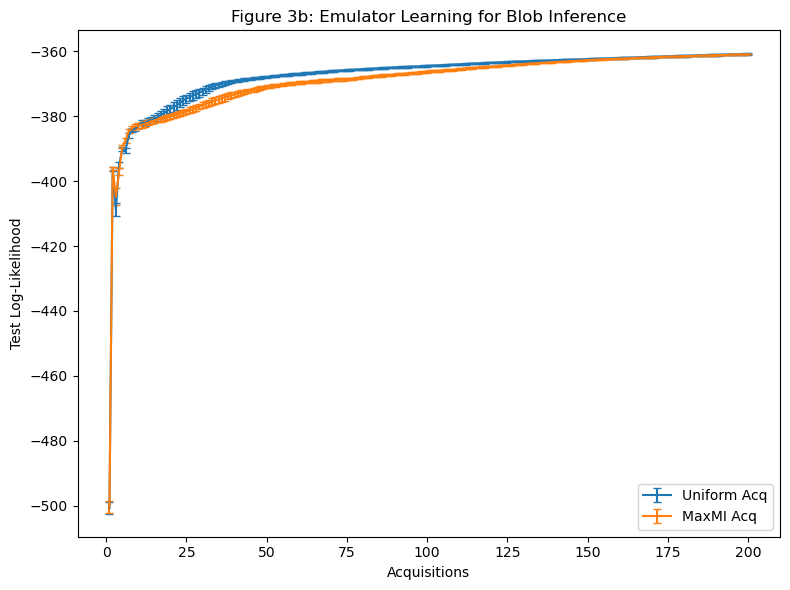

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# --------- Simulator for the Blob Image ----------------------
# Image size: 32 x 32 pixels.
IMG_SIZE = 32
# Create a coordinate grid spanning [-16, 16] in both x and y.
coords = np.linspace(-16, 16, IMG_SIZE)
X_grid, Y_grid = np.meshgrid(coords, coords)  # shape: (32,32)

def simulator_blob(params, sigma=2.0, n_trials=255):
    """
    Simulator for a blob image.
    
    Parameters:
      params: [xoff, yoff, gamma] (each a scalar)
      sigma: fixed sigma parameter (used in the exponent)
      n_trials: binomial total count (here 255)
    
    Returns:
      image: a 32x32 array; pixel intensities normalized to [0,1]
    """
    xoff, yoff, gamma = params
    # Compute squared distance for each pixel from the blob center.
    r2 = (X_grid - xoff)**2 + (Y_grid - yoff)**2
    # Compute per-pixel activation probability.
    p = 0.9 - 0.8 * np.exp( -0.5 * ((r2) / (sigma**2))**gamma )
    # Draw pixel values from Binomial(n_trials, p) for each pixel.
    # (Alternatively, one could use np.random.binomial on the flattened array.)
    image = np.random.binomial(n_trials, p)
    # Normalize image to [0,1]
    return image.astype(np.float32) / n_trials

# --------- Held-out Test Set -----------------------
def generate_test_set(N=500):
    """
    Generate a test set of (params, image) pairs.
    Priors:
      xoff, yoff ~ Uniform(-16, 16)
      gamma ~ Uniform(0.25, 5)
    """
    params = np.zeros((N, 3))
    params[:, 0] = np.random.uniform(-16, 16, size=N)  # xoff
    params[:, 1] = np.random.uniform(-16, 16, size=N)  # yoff
    params[:, 2] = np.random.uniform(0.25, 5, size=N)    # gamma
    images = np.array([simulator_blob(p) for p in params])
    # Flatten images to vectors
    images = images.reshape(N, -1)
    return params, images

test_params, test_images = generate_test_set(N=500)

def compute_test_loglikelihood(models, params, images):
    """
    Compute the (average) log-likelihood of the test set under the ensemble model.
    
    For each test sample, we compute the ensemble-averaged prediction (averaged
    output probability over ensemble members) and then compute the pixel-wise
    log likelihood (using binary cross entropy, neglecting constant terms).
    
    Returns: average log likelihood per image.
    """
    models_out = []
    params_tensor = torch.tensor(params, dtype=torch.float32)
    with torch.no_grad():
        for model in models:
            model.eval()
            pred = model(params_tensor).cpu().numpy()  # shape: (N, 1024)
            models_out.append(pred)
    models_out = np.array(models_out)  # shape: (ensemble_size, N, 1024)
    # Average across ensemble members
    avg_pred = np.mean(models_out, axis=0)  # shape: (N, 1024)
    # Clamp predictions to avoid log(0)
    avg_pred = np.clip(avg_pred, 1e-6, 1-1e-6)
    # Compute log likelihood for each pixel using the Bernoulli log-probability:
    # ll = target*log(pred) + (1-target)*log(1-pred)
    ll = test_images * np.log(avg_pred) + (1 - test_images) * np.log(1 - avg_pred)
    # Sum over pixels per image, then average over test set.
    ll_per_sample = np.sum(ll, axis=1)
    return np.mean(ll_per_sample)

# --------- Emulator Network Definition ---------------------------
class BlobEmulator(nn.Module):
    """
    Neural network emulator for the blob image.
    Inputs: 3-dimensional parameters: [xoff, yoff, gamma]
    Architecture: Two hidden layers (200 units each, ReLU activations)
    Output: 1024 neurons (flattened 32x32 image), with sigmoid activation to yield probabilities.
    """
    def __init__(self):
        super(BlobEmulator, self).__init__()
        self.fc1 = nn.Linear(3, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, IMG_SIZE * IMG_SIZE)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

def bce_loss(pred, target):
    """
    Binary cross entropy loss per sample.
    pred and target are of shape (batch, 1024).
    """
    return F.binary_cross_entropy(pred, target, reduction='mean')

# --------- Training and Acquisition Functions ---------------------------
def train_ensemble(models, optimizers, train_params, train_images, epochs=5):
    """
    Train each model in the ensemble on the given training data.
    Data: train_params (N x 3) and train_images (N x 1024)
    """
    models_tensor = torch.tensor(train_params, dtype=torch.float32)
    images_tensor = torch.tensor(train_images, dtype=torch.float32)
    for epoch in range(epochs):
        for model, optimizer in zip(models, optimizers):
            model.train()
            optimizer.zero_grad()
            pred = model(models_tensor)
            loss = bce_loss(pred, images_tensor)
            loss.backward()
            optimizer.step()

def ensemble_predict(models, candidate_params):
    """
    For a set of candidate parameters (K x 3), compute ensemble predictions.
    Returns an array of shape (K, ensemble_size, 1024).
    """
    candidate_tensor = torch.tensor(candidate_params, dtype=torch.float32)
    predictions = []
    with torch.no_grad():
        for model in models:
            model.eval()
            pred = model(candidate_tensor).cpu().numpy()
            predictions.append(pred)
    predictions = np.array(predictions)  # shape: (ensemble_size, K, 1024)
    return np.transpose(predictions, (1, 0, 2))  # shape: (K, ensemble_size, 1024)

def acquisition_maxmi(models, candidate_params):
    """
    For each candidate parameter in candidate_params (K x 3), compute the average per-pixel variance
    across the ensemble. Return the candidate with the maximum average variance.
    (This variance is used as a proxy for the mutual-information-based acquisition rule.)
    """
    preds = ensemble_predict(models, candidate_params)  # shape: (K, ensemble_size, 1024)
    # Compute variance across ensemble at each candidate and average over pixels:
    var_per_candidate = np.var(preds, axis=1).mean(axis=1)
    idx = np.argmax(var_per_candidate)
    return candidate_params[idx]

def acquisition_uniform():
    """Uniformly sample a candidate from the prior."""
    xoff = np.random.uniform(-16, 16)
    yoff = np.random.uniform(-16, 16)
    gamma = np.random.uniform(0.25, 5)
    return np.array([xoff, yoff, gamma])

# --------- Active Learning Loop for the Image Emulator --------------
def run_active_learning(acquisition_rule='maxmi',
                        N_initial=50, N_acq=200, ensemble_size=10, train_epochs=5):
    """
    Run active learning for the image emulator.
    
    Parameters:
      acquisition_rule: 'maxmi' or 'uniform'
      N_initial: initial number of training samples
      N_acq: number of acquisitions (active learning rounds)
      ensemble_size: number of models in the ensemble
      train_epochs: number of training epochs per acquisition round
      
    Returns:
      test_lls: list of test log-likelihood (performance) at each acquisition round.
    """
    # Generate initial training data from the prior.
    train_params = []
    train_images = []
    for _ in range(N_initial):
        # Sample parameters from the prior
        xoff = np.random.uniform(-16, 16)
        yoff = np.random.uniform(-16, 16)
        gamma = np.random.uniform(0.25, 5)
        params = np.array([xoff, yoff, gamma])
        img = simulator_blob(params)  # shape: (32,32)
        train_params.append(params)
        train_images.append(img.reshape(-1))
    train_params = np.array(train_params)
    train_images = np.array(train_images)
    
    # Initialize ensemble of models and corresponding optimizers.
    models = [BlobEmulator() for _ in range(ensemble_size)]
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]
    
    # Set up candidate grid for acquisition (for MaxMI) by sampling many candidates
    candidate_grid = np.zeros((1000, 3))
    candidate_grid[:, 0] = np.random.uniform(-16, 16, size=1000)
    candidate_grid[:, 1] = np.random.uniform(-16, 16, size=1000)
    candidate_grid[:, 2] = np.random.uniform(0.25, 5, size=1000)
    
    test_lls = []  # performance (average log-likelihood) on the held-out test set at each round
    
    for acq in range(N_acq):
        # Retrain the ensemble on current training data.
        train_ensemble(models, optimizers, train_params, train_images, epochs=train_epochs)
        
        # Evaluate performance on test set.
        test_ll = compute_test_loglikelihood(models, test_params, test_images)
        test_lls.append(test_ll)
        
        # Acquisition: choose a new candidate parameter.
        if acquisition_rule == 'maxmi':
            new_param = acquisition_maxmi(models, candidate_grid)
        elif acquisition_rule == 'uniform':
            new_param = acquisition_uniform()
        else:
            raise ValueError("Unknown acquisition_rule. Choose 'maxmi' or 'uniform'.")
        
        # Simulate a new training example with the selected parameter.
        new_img = simulator_blob(new_param)
        train_params = np.concatenate([train_params, new_param.reshape(1, -1)], axis=0)
        train_images = np.concatenate([train_images, new_img.reshape(1, -1)], axis=0)
        
    return test_lls

# --------- Evaluate Over Multiple Runs and Plot Results ---------------
def evaluate_active_learning(N_runs=20, acquisition_rule='maxmi'):
    performance_runs = []
    for run in trange(N_runs):
        print(f"Run {run+1}/{N_runs} for {acquisition_rule} acquisition...")
        test_lls = run_active_learning(acquisition_rule=acquisition_rule)
        performance_runs.append(test_lls)
    performance_runs = np.array(performance_runs)  # shape: (N_runs, N_acq)
    return performance_runs

# Run evaluations for both acquisition methods.
N = 5
perf_maxmi = evaluate_active_learning(N_runs = N, acquisition_rule='maxmi')
perf_uniform = evaluate_active_learning(N_runs = N, acquisition_rule='uniform')

acq_rounds = np.arange(1, 201)
mean_maxmi = perf_maxmi.mean(axis=0)
sem_maxmi = perf_maxmi.std(axis=0) / np.sqrt(perf_maxmi.shape[0])
mean_uniform = perf_uniform.mean(axis=0)
sem_uniform = perf_uniform.std(axis=0) / np.sqrt(perf_uniform.shape[0])

# Plot Figure 3b: Held-out log-likelihood vs. acquisition rounds.
plt.figure(figsize=(8, 6))
plt.errorbar(acq_rounds, mean_uniform, yerr=sem_uniform, label='Uniform Acq', capsize=3)
plt.errorbar(acq_rounds, mean_maxmi, yerr=sem_maxmi, label='MaxMI Acq', capsize=3)
plt.xlabel('Acquisitions')
plt.ylabel('Test Log-Likelihood')
plt.title('Figure 3b: Emulator Learning for Blob Inference')
plt.legend()
plt.tight_layout()
plt.show()


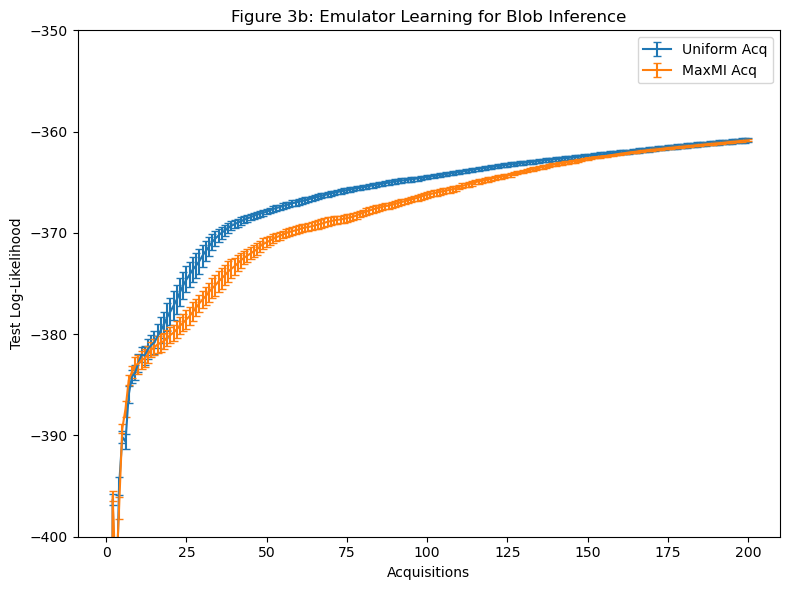

In [7]:
# Plot Figure 3b: Held-out log-likelihood vs. acquisition rounds.
plt.figure(figsize=(8, 6))
plt.errorbar(acq_rounds, mean_uniform, yerr=sem_uniform, label='Uniform Acq', capsize=3)
plt.errorbar(acq_rounds, mean_maxmi, yerr=sem_maxmi, label='MaxMI Acq', capsize=3)

plt.ylim((-400, -350))
plt.xlabel('Acquisitions')
plt.ylabel('Test Log-Likelihood')
plt.title('Figure 3b: Emulator Learning for Blob Inference')
plt.legend()
plt.tight_layout()
plt.show()

Run 1/5, batch_size = 1, method = batchbald
Run 2/5, batch_size = 1, method = batchbald
Run 3/5, batch_size = 1, method = batchbald
Run 4/5, batch_size = 1, method = batchbald
Run 5/5, batch_size = 1, method = batchbald
Run 1/5, batch_size = 5, method = batchbald
Run 2/5, batch_size = 5, method = batchbald
Run 3/5, batch_size = 5, method = batchbald
Run 4/5, batch_size = 5, method = batchbald
Run 5/5, batch_size = 5, method = batchbald
Run 1/5, batch_size = 10, method = batchbald
Run 2/5, batch_size = 10, method = batchbald
Run 3/5, batch_size = 10, method = batchbald
Run 4/5, batch_size = 10, method = batchbald
Run 5/5, batch_size = 10, method = batchbald
Run 1/5, batch_size = 20, method = batchbald
Run 2/5, batch_size = 20, method = batchbald
Run 3/5, batch_size = 20, method = batchbald
Run 4/5, batch_size = 20, method = batchbald
Run 5/5, batch_size = 20, method = batchbald
Run 1/5, batch_size = 1, method = uniform
Run 2/5, batch_size = 1, method = uniform
Run 3/5, batch_size = 1, m

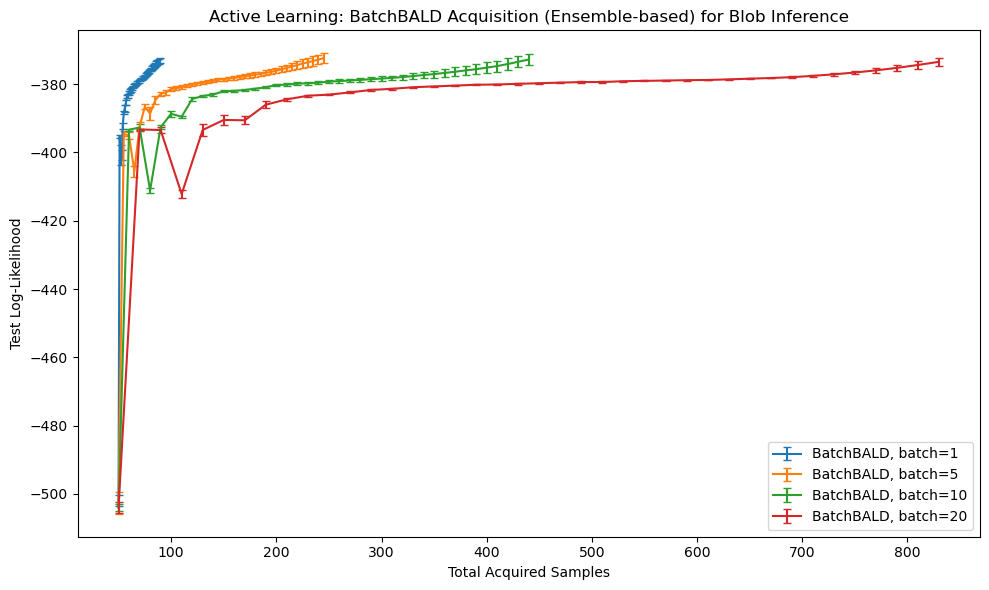

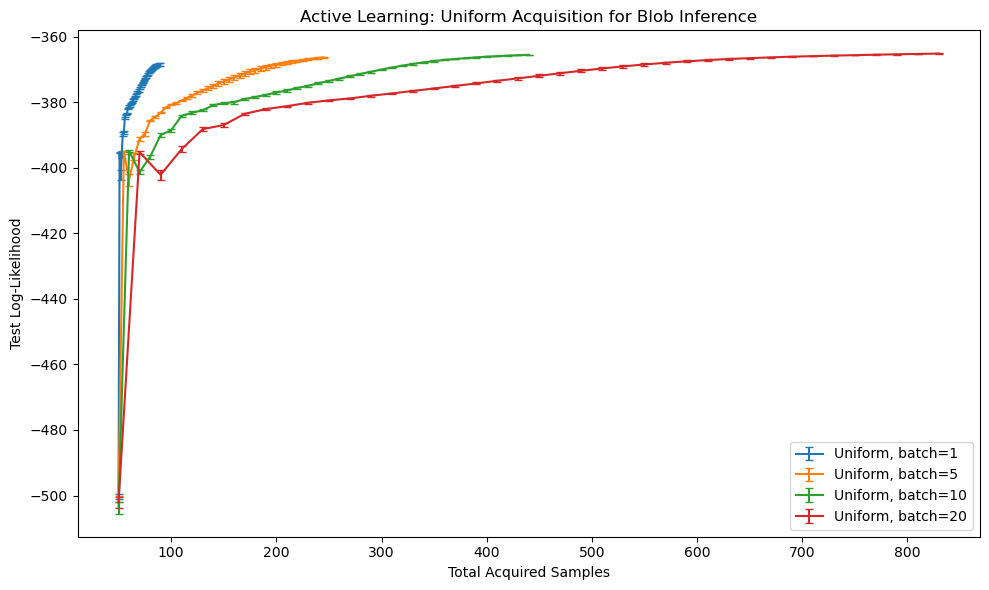

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from numpy.linalg import norm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# Simulator for the Blob Image (32x32, normalized)
# ============================================================================
IMG_SIZE = 32
# Create coordinate grid spanning [-16, 16] in both x and y.
coords = np.linspace(-16, 16, IMG_SIZE)
X_grid, Y_grid = np.meshgrid(coords, coords)  # shape: (32,32)

def simulator_blob(params, sigma=2.0, n_trials=255):
    """
    Simulator for a blob image.
      params: [xoff, yoff, gamma]
      sigma: fixed parameter used in the exponent (set to 2)
      n_trials: binomial total count (here, 255)
    Returns:
      image: 32x32 numpy array normalized to [0,1]
    """
    xoff, yoff, gamma = params
    # Compute squared distance for each pixel from blob center.
    r2 = (X_grid - xoff)**2 + (Y_grid - yoff)**2
    # Compute per-pixel activation probability.
    p = 0.9 - 0.8 * np.exp(-0.5 * ((r2) / (sigma**2))**gamma)
    # Sample pixel values from Binomial
    image = np.random.binomial(n_trials, p)
    return image.astype(np.float32) / n_trials

# ============================================================================
# Generate held-out test set (for evaluation)
# ============================================================================
def generate_test_set(N=500):
    """
    Generate a test set of (params, image) pairs.
      Priors:
         xoff, yoff ~ Uniform(-16, 16)
         gamma ~ Uniform(0.25, 5)
    Returns:
      params: (N x 3) array
      images: (N, 1024) array (flattened images)
    """
    params = np.zeros((N, 3))
    params[:, 0] = np.random.uniform(-16, 16, size=N)  # xoff
    params[:, 1] = np.random.uniform(-16, 16, size=N)  # yoff
    params[:, 2] = np.random.uniform(0.25, 5, size=N)    # gamma
    images = np.array([simulator_blob(p) for p in params])
    images = images.reshape(N, -1)
    return params, images

test_params, test_images = generate_test_set(N=500)

def compute_test_loglikelihood(models, params, images):
    """
    Compute the (average) test log-likelihood of the held-out test set.
    For each test point, the ensemble (of networks) makes predictions (pixel probabilities),
    which are averaged to yield the synthetic likelihood; then the binary cross entropy log–likelihood
    (per pixel) is computed and summed over pixels.
    """
    models_out = []
    params_tensor = torch.tensor(params, dtype=torch.float32)
    with torch.no_grad():
        for model in models:
            model.eval()
            pred = model(params_tensor).cpu().numpy()  # shape: (N, 1024)
            models_out.append(pred)
    models_out = np.array(models_out)  # shape: (ensemble_size, N, 1024)
    # Ensemble average
    avg_pred = np.mean(models_out, axis=0)
    avg_pred = np.clip(avg_pred, 1e-6, 1 - 1e-6)
    ll = images * np.log(avg_pred) + (1 - images) * np.log(1 - avg_pred)
    ll_per_sample = np.sum(ll, axis=1)
    return np.mean(ll_per_sample)

# ============================================================================
# Blob Emulator Network Definition
# ============================================================================
class BlobEmulator(nn.Module):
    """
    Neural network emulator for the blob image.
      Input: 3-dimensional parameters [xoff, yoff, gamma]
      Architecture: two hidden layers (200 units each, ReLU)
      Output: 1024 neurons (flattened image) passed through a sigmoid.
    """
    def __init__(self):
        super(BlobEmulator, self).__init__()
        self.fc1 = nn.Linear(3, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, IMG_SIZE * IMG_SIZE)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

def bce_loss(pred, target):
    return F.binary_cross_entropy(pred, target, reduction='mean')

# ============================================================================
# Training and Standard Acquisition Functions
# ============================================================================
def train_ensemble(models, optimizers, train_params, train_images, epochs=5):
    """
    Train each model in the ensemble on the current training data.
    train_params: (N x 3), train_images: (N x 1024)
    """
    X = torch.tensor(train_params, dtype=torch.float32)
    Y = torch.tensor(train_images, dtype=torch.float32)
    for epoch in range(epochs):
        for model, optimizer in zip(models, optimizers):
            model.train()
            optimizer.zero_grad()
            pred = model(X)
            loss = bce_loss(pred, Y)
            loss.backward()
            optimizer.step()

def acquisition_uniform(batch_size):
    """Uniformly sample a batch from the prior."""
    batch = []
    for _ in range(batch_size):
        xoff = np.random.uniform(-16, 16)
        yoff = np.random.uniform(-16, 16)
        gamma = np.random.uniform(0.25, 5)
        batch.append(np.array([xoff, yoff, gamma]))
    return np.array(batch)

# ============================================================================
# BALD Score and Greedy BatchBALD Acquisition Function
# ============================================================================
def binary_entropy(p):
    """Compute binary entropy for probability p."""
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

def compute_bald_score(models, candidate):
    """
    For a given candidate parameter, compute the BALD score.
    We compute the ensemble predictions (for the flattened 1024-pixel output).
    BALD score = entropy(avg_pred) - average(entropy(pred_i)) summed (or averaged) over pixels.
    """
    candidate_tensor = torch.tensor(candidate.reshape(1, -1), dtype=torch.float32)
    preds = []
    with torch.no_grad():
        for model in models:
            model.eval()
            pred = model(candidate_tensor).cpu().numpy().flatten()  # shape: (1024,)
            preds.append(pred)
    preds = np.array(preds)  # (ensemble_size, 1024)
    avg_pred = np.mean(preds, axis=0)
    # Compute per-pixel binary entropies
    entropy_avg = np.sum(binary_entropy(avg_pred))
    entropy_ind = np.mean([np.sum(binary_entropy(p)) for p in preds])
    bald_score = entropy_avg - entropy_ind
    return bald_score

def cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two 1D numpy vectors."""
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2) + 1e-8)

def greedy_batchbald(models, candidate_pool, batch_size, diversity_coef=0.5):
    """
    Greedy batch acquisition inspired by BatchBALD.
    Inputs:
      models: ensemble of emulator networks.
      candidate_pool: (K x 3) candidate parameters.
      batch_size: size of the batch to acquire.
      diversity_coef: coefficient (0 to 1) that scales the diversity term.
    Returns:
      selected: array of shape (batch_size, 3)
    The idea is to score each candidate x as:
       score(x) = BALD(x) * (1 - diversity_coef * max_{y in batch} similarity(avg_pred(x), avg_pred(y)))
    and greedily pick the candidate with maximum adjusted score.
    """
    selected = []
    # Precompute ensemble predictions for candidate pool for speed.
    candidate_preds = []
    for candidate in candidate_pool:
        candidate_tensor = torch.tensor(candidate.reshape(1, -1), dtype=torch.float32)
        preds = []
        with torch.no_grad():
            for model in models:
                model.eval()
                pred = model(candidate_tensor).cpu().numpy().flatten()
                preds.append(pred)
        candidate_preds.append(np.mean(np.array(preds), axis=0))  # average prediction vector (length 1024)
    candidate_preds = np.array(candidate_preds)  # shape: (K, 1024)
    
    # Compute individual BALD scores for candidate pool.
    bald_scores = np.array([compute_bald_score(models, cand) for cand in candidate_pool])
    
    selected_indices = []
    for i in range(batch_size):
        adjusted_scores = np.copy(bald_scores)
        # For each candidate, if batch is non-empty, penalize high similarity with any already selected.
        if selected_indices:
            for j, cand_pred in enumerate(candidate_preds):
                # Compute maximum cosine similarity with any candidate in the selected batch.
                similarities = [cosine_similarity(cand_pred, candidate_preds[idx]) for idx in selected_indices]
                max_sim = max(similarities)
                # Penalize (if similar, reduce score)
                adjusted_scores[j] *= (1 - diversity_coef * max_sim)
        # Among candidates not yet selected, choose the one with highest adjusted score.
        remaining = [j for j in range(len(candidate_pool)) if j not in selected_indices]
        if len(remaining) == 0:
            break
        j_star = remaining[np.argmax(adjusted_scores[remaining])]
        selected_indices.append(j_star)
    selected = candidate_pool[selected_indices]
    return selected

# ============================================================================
# Active Learning Loop with Batch Acquisition
# ============================================================================
def run_active_learning_batch(acquisition_method='batchbald', batch_size=5, 
                              N_initial=50, N_rounds=40, ensemble_size=10, train_epochs=5):
    """
    Active learning loop for the blob image emulator using batch acquisitions.
    acquisition_method: 'batchbald' or 'uniform'
    batch_size: number of samples acquired per round.
    N_initial: initial training set size.
    N_rounds: number of active learning rounds (each adds batch_size points).
    ensemble_size: number of ensemble networks.
    train_epochs: training epochs per round.
    Returns:
      test_lls: a list of test log-likelihoods after each round.
      total_acquisitions: corresponding total number of acquired samples.
    """
    # Create initial training data.
    train_params = []
    train_images = []
    for _ in range(N_initial):
        xoff = np.random.uniform(-16, 16)
        yoff = np.random.uniform(-16, 16)
        gamma = np.random.uniform(0.25, 5)
        params = np.array([xoff, yoff, gamma])
        img = simulator_blob(params)
        train_params.append(params)
        train_images.append(img.reshape(-1))
    train_params = np.array(train_params)
    train_images = np.array(train_images)
    
    # Initialize ensemble.
    models = [BlobEmulator() for _ in range(ensemble_size)]
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]
    
    test_lls = []
    total_acqs = []
    
    # For batch acquisition, define a candidate pool. We sample a relatively large pool.
    pool_size = 1000
    candidate_pool = np.zeros((pool_size, 3))
    candidate_pool[:, 0] = np.random.uniform(-16, 16, size=pool_size)
    candidate_pool[:, 1] = np.random.uniform(-16, 16, size=pool_size)
    candidate_pool[:, 2] = np.random.uniform(0.25, 5, size=pool_size)
    
    for r in range(N_rounds):
        # Retrain ensemble on current data.
        train_ensemble(models, optimizers, train_params, train_images, epochs=train_epochs)
        # Evaluate performance on test set.
        test_ll = compute_test_loglikelihood(models, test_params, test_images)
        test_lls.append(test_ll)
        total_acqs.append(len(train_params))
        
        # Replenish candidate pool (simulate new candidates) so that scores are current.
        candidate_pool[:, 0] = np.random.uniform(-16, 16, size=pool_size)
        candidate_pool[:, 1] = np.random.uniform(-16, 16, size=pool_size)
        candidate_pool[:, 2] = np.random.uniform(0.25, 5, size=pool_size)
        
        # Batch acquisition.
        if acquisition_method == 'batchbald':
            batch = greedy_batchbald(models, candidate_pool, batch_size, diversity_coef=0.5)
        elif acquisition_method == 'uniform':
            batch = acquisition_uniform(batch_size)
        else:
            raise ValueError("Unknown acquisition_method.")
        
        # Simulate new training samples for each acquired candidate.
        new_params = []
        new_images = []
        for params in batch:
            img = simulator_blob(params)
            new_params.append(params)
            new_images.append(img.reshape(-1))
        new_params = np.array(new_params)
        new_images = np.array(new_images)
        
        # Add the new batch to the training set.
        train_params = np.concatenate([train_params, new_params], axis=0)
        train_images = np.concatenate([train_images, new_images], axis=0)
    return test_lls, total_acqs

# ============================================================================
# Evaluate over Multiple Runs for Different Batch Sizes
# ============================================================================
def evaluate_batch_acquisitions(N_runs=5, batch_sizes=[1, 5, 10, 20], 
                                acquisition_method='batchbald', N_initial=50, N_rounds=40,
                                ensemble_size=10, train_epochs=5):
    """
    For each batch size, run multiple active learning loops and record the test log-likelihood curve.
    Returns a dictionary mapping batch_size to an array of shape (N_runs, N_rounds) of test log-likelihoods.
    """
    results = {}
    for b in batch_sizes:
        all_runs = []
        for run in range(N_runs):
            print(f"Run {run+1}/{N_runs}, batch_size = {b}, method = {acquisition_method}")
            test_lls, _ = run_active_learning_batch(acquisition_method=acquisition_method, batch_size=b,
                                                    N_initial=N_initial, N_rounds=N_rounds, 
                                                    ensemble_size=ensemble_size, train_epochs=train_epochs)
            all_runs.append(test_lls)
        results[b] = np.array(all_runs)
    return results

# Choose batch sizes to compare.
batch_sizes = [1, 5, 10, 20]  # acquisition size 1 is like pointwise BALD
results_batchbald = evaluate_batch_acquisitions(N_runs=5, batch_sizes=batch_sizes, 
                                                 acquisition_method='batchbald', N_initial=50, N_rounds=40,
                                                 ensemble_size=10, train_epochs=5)
results_uniform = evaluate_batch_acquisitions(N_runs=5, batch_sizes=batch_sizes, 
                                               acquisition_method='uniform', N_initial=50, N_rounds=40,
                                               ensemble_size=10, train_epochs=5)

# ============================================================================
# Plotting the Results (Test Log-Likelihood vs. Total Acquired Samples)
# ============================================================================
plt.figure(figsize=(10, 6))
for b in batch_sizes:
    mean_ll = results_batchbald[b].mean(axis=0)
    sem_ll = results_batchbald[b].std(axis=0) / np.sqrt(results_batchbald[b].shape[0])
    total_points = 50 + np.arange(40) * b
    plt.errorbar(total_points, mean_ll, yerr=sem_ll, capsize=3, label=f'BatchBALD, batch={b}')

plt.xlabel('Total Acquired Samples')
plt.ylabel('Test Log-Likelihood')
plt.title('Active Learning: BatchBALD Acquisition (Ensemble-based) for Blob Inference')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for b in batch_sizes:
    mean_ll = results_uniform[b].mean(axis=0)
    sem_ll = results_uniform[b].std(axis=0) / np.sqrt(results_uniform[b].shape[0])
    total_points = 50 + np.arange(40) * b
    plt.errorbar(total_points, mean_ll, yerr=sem_ll, capsize=3, label=f'Uniform, batch={b}')

plt.xlabel('Total Acquired Samples')
plt.ylabel('Test Log-Likelihood')
plt.title('Active Learning: Uniform Acquisition for Blob Inference')
plt.legend()
plt.tight_layout()
plt.show()
